In [1]:
import random
import numpy as np
from numpy.linalg import norm as vector_norm
import matplotlib.pyplot as plt
from itertools import product
from sklearn import datasets

import sys
sys.path.append('../modules')
from nsw.nsw_classifier import NSWClassifier
from nsw.cut_classifier import CutClassifier

# 100 leaves dataset

In [2]:
import random

margin_file = "../data/100leaves/data_Mar_64.txt"

curly = ["Betula Pendula", "Populus Nigra", "Quercus Brantii", 
         "Quercus Canariensis", "Quercus Castaneifolia", "Quercus Infectoria sub",
         "Castanea Sativa", "Morus Nigra", "Prunus X Shmittii",
         "Acer Campestre", "Acer Circinatum", "Acer Mono", "Acer Palmatum", 
         "Acer Platanoids", "Acer Rubrum", "Acer Rufinerve", "Acer Saccharinum", 
         "Liquidambar Styraciflua", "Liriodendron Tulipifera", 
         "Quercus Ellipsoidalis", "Quercus Palustris", "Quercus Pubescens", 
         "Ilex Aquifolium", "Quercus Coccifera", "Quercus Greggii",
         
         "Quercus Pyrenaica", "Quercus Rubra", 
         "Quercus Shumardii", "Quercus Texana","Quercus Vulcanica",
         "Acer Opalus", "Acer Pictum", 
         "Crataegus Monogyna", "Quercus Cerris",
         "Quercus Coccinea", "Quercus Afares",
         "Quercus Hartwissiana", "Quercus Kewensis",
         "Zelkova Serrata", "Populus Grandidentata",
         "Quercus Alnifolia", "Quercus Semecarpifolia",
         "Quercus x Turneri", "Sorbus Aria", "Ginkgo Biloba",
        ]

dataset = []
d = dict((c, 0) for c in curly)
for line in open(margin_file):
    
    parts = line.strip().split(',')
    class_, vect = parts[0], np.array(list(map(float, parts[1:])))
    dataset.append((vect, int(class_ in curly)))
    if class_ in d:
        d[class_] += 1

print(d)
print("Non-curly", len([v for v in dataset if v[1] == 0]))
print("Curly", len([v for v in dataset if v[1] == 1]))

nc = [v for v in dataset if v[1] == 0]
cu = [v for v in dataset if v[1] == 1]

curlycount = len(cu)
noncurlycount = len(nc)

if noncurlycount > curlycount:
    random.shuffle(nc)
    dataset = nc[:curlycount] + cu

random.shuffle(dataset)
print("Dataset len", len(dataset))   

{'Betula Pendula': 16, 'Populus Nigra': 16, 'Quercus Brantii': 16, 'Quercus Canariensis': 16, 'Quercus Castaneifolia': 16, 'Quercus Infectoria sub': 16, 'Castanea Sativa': 16, 'Morus Nigra': 16, 'Prunus X Shmittii': 16, 'Acer Campestre': 16, 'Acer Circinatum': 16, 'Acer Mono': 16, 'Acer Palmatum': 16, 'Acer Platanoids': 16, 'Acer Rubrum': 16, 'Acer Rufinerve': 16, 'Acer Saccharinum': 16, 'Liquidambar Styraciflua': 16, 'Liriodendron Tulipifera': 16, 'Quercus Ellipsoidalis': 16, 'Quercus Palustris': 16, 'Quercus Pubescens': 16, 'Ilex Aquifolium': 16, 'Quercus Coccifera': 16, 'Quercus Greggii': 16, 'Quercus Pyrenaica': 16, 'Quercus Rubra': 16, 'Quercus Shumardii': 16, 'Quercus Texana': 16, 'Quercus Vulcanica': 16, 'Acer Opalus': 16, 'Acer Pictum': 16, 'Crataegus Monogyna': 16, 'Quercus Cerris': 16, 'Quercus Coccinea': 16, 'Quercus Afares': 16, 'Quercus Hartwissiana': 16, 'Quercus Kewensis': 16, 'Zelkova Serrata': 16, 'Populus Grandidentata': 16, 'Quercus Alnifolia': 16, 'Quercus Semecarpi

In [3]:
train_leaves, test_leaves = dataset[:9 * len(dataset) // 10], dataset[9 * len(dataset) // 10:]
print(f"train {len(train_leaves)}; test {len(test_leaves)}")
leaves_classifier = NSWClassifier()
leaves_classifier.build_navigable_graph(train_leaves, attempts=10)

train 1296; test 144
Classifier graph is build in 76.190s


Initial cut size 90075


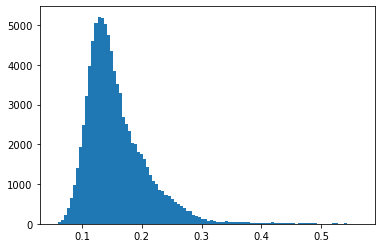

Smaller cut size: 1296


In [4]:
rich_cut = [
            (
                e, 
                leaves_classifier.dist(leaves_classifier.nodes[e[0]].value, leaves_classifier.nodes[e[1]].value)
            ) 
            for e in leaves_classifier.cut
           ]
rich_cut.sort(key=lambda v: v[1])
print(f"Initial cut size {len(rich_cut)}")
lengths = [e[1] for e in rich_cut]
plt.hist(lengths, bins=100)
plt.show()
smaller_cut = rich_cut[:len(leaves_classifier.nodes)]
print(f"Smaller cut size: {len(smaller_cut)}")

In [5]:
cclf = CutClassifier(leaves_classifier, smaller_cut)
clf = cclf.classifier

Graph initialized with cut (1296).
Wilson: Data shape 64
Clean cut (1296).
Shortest dist estimated (0.0274).
Support with 129 nodes is created.
Data dimensionality detected is 64. regularity = 192
Support graph is built.
get_grad_field_function: Edge index is prepared.
Classifier function is ready.


In [6]:
true, true0, true1 = 0, 0, 0
for t in test_leaves:
    pc = clf(t[0], small=0.000001, R=1, closest=9, M=16)
    pci = int(pc > .5)
    true += pci == t[1]
    true0 += pci == t[1] and t[1] == 0
    true1 += pci == t[1] and t[1] == 1
    
    print("+" if pci == t[1] else "-", end="")

print("Accuracy", true / len(test_leaves))
tp = true1
fn = sum(t[1] for t in test_leaves) - tp
tn = true0
fp = (len(test_leaves) - sum(t[1] for t in test_leaves)) - tn
f1 = tp / (tp + (fn + fp) / 2)
print("F1 score", f1)
print("predicted \ real |\t0\t|\t1\t|")
print(f"       0         |\t{tn}\t|\t{fn}\t|")
print(f"       1         |\t{fp}\t|\t{tp}\t|")

++++++-+++++++++-+-+-+++++-+++-+++++-+-++++++++-+-+-++++-++++++++++++-+++++--+-+++++++++--+-+++++++---++++++++++++++++-++-+++++++++++-++++++-+++Accuracy 0.8194444444444444
F1 score 0.8266666666666667
predicted \ real |	0	|	1	|
       0         |	56	|	13	|
       1         |	13	|	62	|


In [7]:
k = 9
true, true0, true1 = 0, 0, 0
for t in test_leaves:
    nodes = cclf.support_nsw.multi_search(t[0], attempts=1, top=k)
    classes = [cclf.support_nsw.nodes[n]._class for n in nodes]
    pci = sum(classes) > k // 2
    true += pci == t[1]
    true0 += pci == t[1] and t[1] == 0
    true1 += pci == t[1] and t[1] == 1
    print("+" if pci == t[1] else "-", end="")

print("Accuracy", true / len(test_leaves))
tp = true1
fn = sum(t[1] for t in test_leaves) - tp
tn = true0
fp = (len(test_leaves) - sum(t[1] for t in test_leaves)) - tn
f1 = tp / (tp + (fn + fp) / 2)
print("F1 score", f1)
print("predicted \ real |\t0\t|\t1\t|")
print(f"       0         |\t{tn}\t|\t{fn}\t|")
print(f"       1         |\t{fp}\t|\t{tp}\t|")

++-+++++++++++++-+-+-+++++-+++-+++++-+-++++++++-+-+-++++-++++++++++++-+++++--+-+++++++++--+-+++++++---++++++++++++++++-++--++++++-++--+++++---++Accuracy 0.7847222222222222
F1 score 0.7832167832167832
predicted \ real |	0	|	1	|
       0         |	57	|	19	|
       1         |	12	|	56	|


In [8]:
true, true0, true1 = 0, 0, 0
for t in test_leaves:
    pci = leaves_classifier.classify_by_path(t[0], attempts=1)
    true += pci == t[1]
    true0 += pci == t[1] and t[1] == 0
    true1 += pci == t[1] and t[1] == 1
    print("+" if pci == t[1] else "-", end="")

print("Accuracy", true / len(test_leaves))
tp = true1
fn = sum(t[1] for t in test_leaves) - tp
tn = true0
fp = (len(test_leaves) - sum(t[1] for t in test_leaves)) - tn
f1 = tp / (tp + (fn + fp) / 2)
print("F1 score", f1)
print("predicted \ real |\t0\t|\t1\t|")
print(f"       0         |\t{tn}\t|\t{fn}\t|")
print(f"       1         |\t{fp}\t|\t{tp}\t|")

++++++++++++++++-+++-+++++-++-++++++++++++++++++++++++++++++++++++++++++++++++++++-++-+-+++++++++++++++++++++++++++++++++-++++++++++++++++++++++Accuracy 0.9444444444444444
F1 score 0.9444444444444444
predicted \ real |	0	|	1	|
       0         |	68	|	7	|
       1         |	1	|	68	|


In [9]:
k = 9
true, true0, true1 = 0, 0, 0
for t in test_leaves:
    pci = leaves_classifier.classify_knn(t[0], k=9, attempts=1)
    true += pci == t[1]
    true0 += pci == t[1] and t[1] == 0
    true1 += pci == t[1] and t[1] == 1
    print("+" if pci == t[1] else "-", end="")

print("Accuracy", true / len(test_leaves))
tp = true1
fn = sum(t[1] for t in test_leaves) - tp
tn = true0
fp = (len(test_leaves) - sum(t[1] for t in test_leaves)) - tn
f1 = tp / (tp + (fn + fp) / 2)
print("F1 score", f1)
print("predicted \ real |\t0\t|\t1\t|")
print(f"       0         |\t{tn}\t|\t{fn}\t|")
print(f"       1         |\t{fp}\t|\t{tp}\t|")

++++++++++++++++-+++-++++++++-++++++++++-++-+++++++++++++++++++-+++++++++++++++++++++-+++-+++++++++-++++++++++++++++++++++++++++++++++++++++-+++Accuracy 0.9305555555555556
F1 score 0.9295774647887324
predicted \ real |	0	|	1	|
       0         |	68	|	9	|
       1         |	1	|	66	|
